In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from scipy.stats import ttest_ind_from_stats

from knn2 import do_cv_knn
from svm2 import do_cv_svm

%matplotlib inline

### 1. Codifique o atributo de saída (class) da seguinte forma: e → 0 e p → 1. Isto será útil para o cálculo da métrica f1_score, mais adiante.

In [34]:
df = pd.read_csv('agaricus_lepiota_small_c.csv')
y = df['class'].replace('e', 0).replace('p', 1).values.ravel()
X = df.drop(['class'], axis=1)

### 2. Realize a imputação para os valores faltantes. Os valores faltantes estão em apenas na coluna “stalk-root”. A estratégia de imputação fica a seu critério. Também há a possibilidade de excluir esta coluna.

#### Como podemos visualizar abaixo, nosso DataFrame possui valores faltantes. Sendo assim, deveremos realizar a técnica de imputação de dados, com objetivo de realizar uma analise mais adequada em nossos dados.

In [35]:
df.isnull().sum()

class                         0
cap-shape                     0
cap-surface                   0
cap-color                     0
bruises                       0
odor                          0
gill-attachment               0
gill-spacing                  0
gill-size                     0
gill-color                    0
stalk-shape                   0
stalk-root                  310
stalk-surface-above-ring      0
stalk-surface-below-ring      0
stalk-color-above-ring        0
stalk-color-below-ring        0
veil-type                     0
veil-color                    0
ring-number                   0
ring-type                     0
spore-print-color             0
population                    0
habitat                       0
dtype: int64

In [36]:
# Campos cat_att (SimpleImputer strategy=most_frequent): a estratégia de imputação de dados utilizada aqui, foi preencher os 
# campos vazios de cada coluna com os valores mais frequentes de cada uma. A estratégia de valor mais frequente para 
# cada coluna foi escolhida, pois existem tipos de cogumelos mais comuns de se encontrar que os outros. Sendo assim,
# generalizei o valor mais comum encontrada nessa coluna.

In [37]:
cat_att = ['stalk-root']

transformers = [
  ['imp_cat', SimpleImputer(strategy='most_frequent'), cat_att]
]

ct_imp = ColumnTransformer(
  transformers, remainder='passthrough'
)

#Realizando imputação
X_imp = ct_imp.fit_transform(X)

#Convertendo para pandas pf
X_alt = X.drop(cat_att, axis=1)


X_imputed = pd.DataFrame(X_imp, columns=[*cat_att, *X_alt.columns.values])
X_imputed

,stalk-root,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,b,x,s,y,t,a,f,w,b,g,...,s,w,w,p,w,o,p,n,v,d
1,e,f,s,y,f,n,f,c,b,p,...,s,w,w,p,w,o,f,n,y,g
2,b,k,s,w,f,c,f,w,b,g,...,s,w,n,p,w,t,e,w,n,g
3,b,f,f,n,t,n,f,c,b,w,...,s,g,w,p,w,o,p,k,v,d
4,e,x,s,w,t,p,f,c,n,w,...,s,w,w,p,w,o,p,n,s,u
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,b,x,f,p,f,c,f,w,n,n,...,s,w,w,p,w,o,p,n,v,d
996,b,x,y,n,f,n,f,c,n,w,...,y,w,y,p,w,o,e,w,v,d
997,b,x,f,g,f,n,f,c,b,u,...,s,g,g,p,w,o,e,k,y,d
998,b,b,s,w,t,a,f,c,b,b,...,s,g,w,p,w,o,p,h,y,p


#### Podemos verificar abaixo que resolvemos os problemas dos atributos faltantes

In [46]:
X_imputed.isnull().sum()

stalk-root                  0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

### Visualizando dados presente em nosso dataset

In [59]:
X_imput_described = X_imputed.copy()
X_imput_described['class'] = df['class'].replace('e', 'Comestivel').replace('p', 'Venenoso')
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

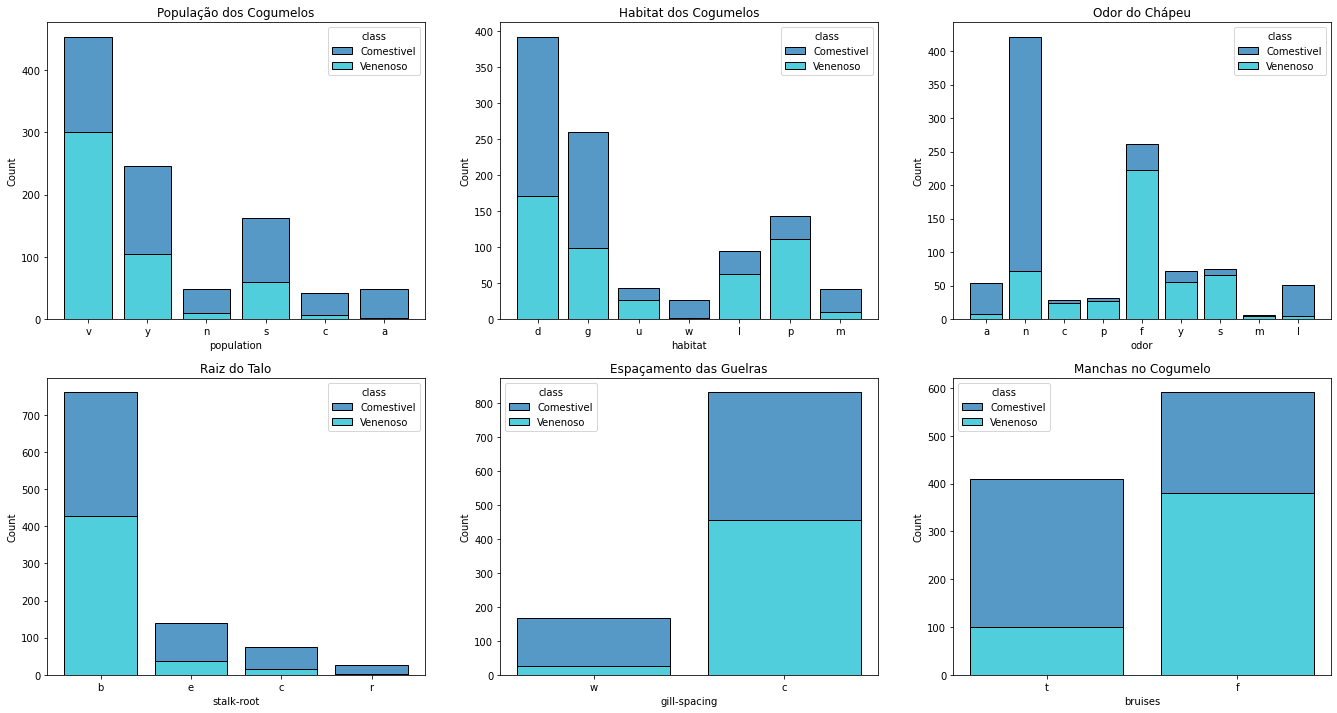

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(23, 12))

x_list = ['population', 'habitat', 'odor', 'stalk-root', 'gill-spacing', 'bruises']
label_list = ['População dos Cogumelos', 'Habitat dos Cogumelos', 
              'Odor do Chápeu', 'Raiz do Talo', 'Espaçamento das Guelras', 'Manchas no Cogumelo']
item_idx = 0

for i in range(0, 2):
  for j in range(0, 3):
    sns.histplot(data=X_imput_described, bins=10, x=x_list[item_idx], hue='class', multiple='stack', shrink=0.8, palette=[colors[0], colors[-1]], ax=axes[i][j])
    axes[i][j].set_title(label_list[item_idx])
    item_idx +=1

#### Considerações

1. Cogumelos coméstiveis tenden a não possuir odor, enquanto a maioria dos cogumelos venenosos possuem algum tipo de odor.

2. Cogumelos venenosos tender a não possuir manchas (contusões) em seu corpo.

2. O espaçamento das guelras dos cogumelos venenosos tendem a ser mais juntos, ou seja, sem muito espaçamento uma da outra.

### 3. Faça a codificação dos atributos categóricos. O arquivo agaricus-lepiota.names explica a significado e os valores relativos a cada atributo da base de dados. De acordo com o significado e os valores de cada atributo decida qual é o codificador mais adequado.

#### Após a imputação dos dados faltantes nosso DataFrame ficará da seguinte form (veja abaixo):

In [76]:
X_imputed

,stalk-root,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,b,x,s,y,t,a,f,w,b,g,...,s,w,w,p,w,o,p,n,v,d
1,e,f,s,y,f,n,f,c,b,p,...,s,w,w,p,w,o,f,n,y,g
2,b,k,s,w,f,c,f,w,b,g,...,s,w,n,p,w,t,e,w,n,g
3,b,f,f,n,t,n,f,c,b,w,...,s,g,w,p,w,o,p,k,v,d
4,e,x,s,w,t,p,f,c,n,w,...,s,w,w,p,w,o,p,n,s,u
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,b,x,f,p,f,c,f,w,n,n,...,s,w,w,p,w,o,p,n,v,d
996,b,x,y,n,f,n,f,c,n,w,...,y,w,y,p,w,o,e,w,v,d
997,b,x,f,g,f,n,f,c,b,u,...,s,g,g,p,w,o,e,k,y,d
998,b,b,s,w,t,a,f,c,b,b,...,s,g,w,p,w,o,p,h,y,p


#### Devemos realizar a conversão dos atributos catégoricos, sendo assim, conforme pode ser visto na Tabela Pandas abaixo, os atributos não possuem relação de ordem, ou seja, utilizaremos o *OneHotEncoder*. 


#### Por conseguinte, para o atributo gill-size, utilizaremos o *OrdinalEncoder*, pois o mesmo possui uma ordem de relação, ou seja, b (Largo) e n (Estreito).

#### Por fim, para o atributo ring-number, utilizaremos novamente o *OrdinalEncoder*, pois o mesmo também possui ordem de relação, ou seja, n (Nenhum), o (Um) e t (Dois).

In [77]:
df_oe = X_imputed[['cap-shape', 'cap-surface', 
          'cap-color', 'bruises', 'odor', 
          'gill-attachment', 'gill-spacing', 
          'gill-color', 'stalk-shape', 'stalk-root', 
          'stalk-surface-above-ring', 'stalk-surface-below-ring',
          'stalk-color-above-ring', 'stalk-color-below-ring',
          'veil-type', 'veil-color', 'ring-type', 'spore-print-color',
          'population', 'habitat']]
df_oe

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-type,spore-print-color,population,habitat
0,x,s,y,t,a,f,w,g,t,b,s,s,w,w,p,w,p,n,v,d
1,f,s,y,f,n,f,c,p,t,e,f,s,w,w,p,w,f,n,y,g
2,k,s,w,f,c,f,w,g,t,b,k,s,w,n,p,w,e,w,n,g
3,f,f,n,t,n,f,c,w,t,b,s,s,g,w,p,w,p,k,v,d
4,x,s,w,t,p,f,c,w,e,e,s,s,w,w,p,w,p,n,s,u
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,x,f,p,f,c,f,w,n,e,b,s,s,w,w,p,w,p,n,v,d
996,x,y,n,f,n,f,c,w,e,b,k,y,w,y,p,w,e,w,v,d
997,x,f,g,f,n,f,c,u,t,b,s,s,g,g,p,w,e,k,y,d
998,b,s,w,t,a,f,c,b,e,b,s,s,g,w,p,w,p,h,y,p


In [79]:

# Realizando a conversão dos atributos

att_oh = ['cap-shape', 'cap-surface', 
          'cap-color', 'bruises', 'odor', 
          'gill-attachment', 'gill-spacing', 
          'gill-color', 'stalk-shape', 'stalk-root', 
          'stalk-surface-above-ring', 'stalk-surface-below-ring',
          'stalk-color-above-ring', 'stalk-color-below-ring',
          'veil-type', 'veil-color', 'ring-type', 'spore-print-color',
          'population', 'habitat']

att_ordinal = ['gill-size', 'ring-number']


transformers_imput_oe = [
  ('oh_encode', OneHotEncoder(), att_oh),
  ('ordinal_encode', OrdinalEncoder(categories=[['n', 'b'], ['n', 'o', 't']]), att_ordinal),
]

ct_imput_ohoe = ColumnTransformer(
  transformers_imput_oe, remainder='passthrough'
)

X_imput_ohoe = ct_imput_ohoe.fit_transform(X_imputed).todense()
X_imput_ohoe


matrix([[0., 0., 0., ..., 0., 1., 1.],
        [0., 1., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 0., 1., 2.],
        ...,
        [0., 0., 0., ..., 0., 1., 1.],
        [1., 0., 0., ..., 0., 1., 1.],
        [0., 0., 0., ..., 0., 0., 1.]])

### 4) Avalie o desempenho do classificador KNN usando validação cruzada em dois níveis, conforme discutimos na Semana 4. A validação cruzada no primeiro deve ser em 10 vias, enquanto no segundo nível deve ser em 5 vias. Dica: no primeiro nível você deve usar StratifiedKFold para gerar os particionamentos, e no segundo nível você deve usar GridSearchCV. A validação cruzada no segundo nível deve selecionar o melhor k. Utilize a métrica f1-score da classe positiva (poisonous) para avaliar o desempenho do classificador em ambos níveis. Dica 1: use o parâmetro scoring no construtor do GridSearchCV para escolher a métrica de desempenho. Dica 2: a função f1_score do módulo sklearn.metrics calcula o f1_score e os parâmetros são os mesmos que usamos com accuracy_score.

In [39]:
knn = do_cv_knn(X_imput_ohoe, y, 10, 5, params={'n_neighbors' : range(1,30,2)}, n_jobs=8)
knn

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

[0.9583333333333334,
 0.9484536082474228,
 0.9690721649484536,
 0.9894736842105264,
 0.9494949494949494,
 0.9583333333333334,
 0.9787234042553191,
 0.9787234042553191,
 0.9387755102040817,
 0.9896907216494846]

### 5. Avalie o desempenho do classificador SVM usando validação cruzada em dois níveis, da mesma forma que no item 3. A validação cruzada no segundo nível deve selecionar a melhor combinação de C e gamma (γ) de acordo com o que vimos na aula síncrona. Use o kernel rbf.

In [40]:
svm = do_cv_svm(X_imput_ohoe, y, 10, 5, params={'C' : [1, 10, 100, 1000], 'gamma' : ['auto', 'scale', 2e-2, 2e-3, 2e-4], 'kernel': ['rbf']}, n_jobs=8)
svm

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

[0.9473684210526315,
 0.9484536082474228,
 0.9387755102040817,
 0.9484536082474228,
 0.9591836734693877,
 0.967741935483871,
 0.9473684210526315,
 0.9787234042553191,
 0.9494949494949495,
 0.9896907216494846]

### 6. Faça o teste da hipótese nula (pelo Teste-T) para verificar se os resultados obtidos com o KNN e com a SVM são estatisticamente diferentes com 95% de confiança. Interprete o resultado do teste.

In [41]:
def calcular_estatisticas(resultados):
    return np.mean(resultados), np.std(resultados), np.min(resultados), np.max(resultados)

def imprimir_estatisticas(resultados):
    media, desvio, mini, maxi = calcular_estatisticas(resultados)
    print("Resultados: %.2f +- %.2f, min: %.2f, max: %.2f" % (media, desvio, mini, maxi))
    

In [42]:
media_knn, std_knn, _, _ = calcular_estatisticas(knn)
media_svm, std_svm, _, _ = calcular_estatisticas(svm)

_, pvalor = ttest_ind_from_stats(media_knn, std_knn, len(knn), media_svm, std_svm, len(svm))

In [43]:
pvalor


0.26301306181902157

In [44]:
print("Média SVM:", media_svm)
print("Média KNN:", media_knn)

Média SVM: 0.9575254253157203
Média KNN: 0.9659074113932224


In [45]:
alpha = 0.05
trusty = (1 - alpha)*100
name_best_mean = 'KNN' if (media_knn > media_svm) else 'SVM'
best_mean = max(media_knn, media_svm) 

if(pvalor <= alpha):
  print("\U00002B55 Conclusão, ")
  print("Como nosso ponto de corte (p-value)=%.5f deve ser no máximo alpha=%.5f, ou seja, o nível de confiança deve ser no mínimo %d%%, a hipótese nula será rejeitada \U0000274C." % (pvalor, alpha, trusty))
  print("Sendo assim, concluímos que a média dos classificadores não são estatisticamente equivalentes.")
  print("Desta forma, é valido afirmar que o classificador com a maior média será a melhor escolha para o nosso problema.")
  print("Doravante, o classificador escolhido foi o %s, com a média de %.10f..." % (name_best_mean, best_mean))
else:
  print("\U00002B55 Conclusão,")
  print("Como nosso ponto de corte (p-value)=%.5f é maior que alpha=%.5f, ou seja, não foi atingido o nível de confiança mínima exigido (%d%%), a hipótese nula será aceita \U00002705." % (pvalor, alpha, trusty))
  print("Sendo assim, concluimos que não existe diferença significativa entre as médias dos classificadores, ou seja, os mesmos são equivalentes.")
  print("Doravate, podemos escolher qualquer um dos classificadores para o nosso problema.")
  
  

⭕ Conclusão,
Como nosso ponto de corte (p-value)=0.26301 é maior que alpha=0.05000, ou seja, não foi atingido o nível de confiança mínima exigido (95%), a hipótese nula será aceita ✅.
Sendo assim, concluimos que não existe diferença significativa entre as médias dos classificadores, ou seja, os mesmos são equivalentes.
Doravate, podemos escolher qualquer um dos classificadores para o nosso problema.


### 7. Você usaria algum classificador que criou para decidir se comeria ou não um cogumelo classificado por ele? Justifique usando o desempenho obtido e o resultado do teste de hipótese.